In [ ]:
import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import timm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from PIL import Image
from src.data import *


In [29]:
# Patchify and unpatchify helpers (like in MAE official)
def patchify(x, patch_size):
    B, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0

    h = H // patch_size
    w = W // patch_size
    x = x.reshape(B, C, h, patch_size, w, patch_size)
    x = x.permute(0, 2, 4, 3, 5, 1)
    patches = x.reshape(B, h * w, patch_size * patch_size * C)
    return patches

def unpatchify(x, patch_size, img_size):
    B, N, patch_dim = x.shape
    H, W = img_size, img_size
    h = H // patch_size
    w = W // patch_size
    x = x.reshape(B, h, w, patch_size, patch_size, 3)
    x = x.permute(0, 5, 1, 3, 2, 4)
    imgs = x.reshape(B, 3, H, W)
    return imgs


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, D, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)  # (B, N, D)
        return x


class MAE(nn.Module):
    def __init__(
        self,
        img_size=256,
        patch_size=16,
        encoder_dim=768,
        decoder_dim=512,
        encoder_depth=12,
        decoder_depth=4,
        num_heads=12,
        mask_ratio=0.75,
    ):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = PatchEmbed(img_size, patch_size, 3, encoder_dim)

        # Positional embeddings
        self.encoder_pos_embed = nn.Parameter(torch.randn(1, self.num_patches, encoder_dim))
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, self.num_patches, decoder_dim))

        # Mask token
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))

        # ViT Encoder
        self.encoder_blocks = nn.Sequential(*[
            nn.TransformerEncoderLayer(d_model=encoder_dim, nhead=num_heads)
            for _ in range(encoder_depth)
        ])
        self.encoder_norm = nn.LayerNorm(encoder_dim)

        # Projection for decoder input
        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim)

        # ViT Decoder
        self.decoder_blocks = nn.Sequential(*[
            nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=16)
            for _ in range(decoder_depth)
        ])
        self.decoder_norm = nn.LayerNorm(decoder_dim)

        # Final prediction: reconstruct each patch (3 * patch_size^2)
        self.head = nn.Linear(decoder_dim, patch_size**2 * 3)

    def random_masking(self, x):
        N, L, D = x.shape
        len_keep = int(L * (1 - self.mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise for each patch
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward(self, imgs):
        # Patchify input
        x = self.patch_embed(imgs)  # (B, N, D)
        x = x + self.encoder_pos_embed[:, :x.size(1), :]

        # Apply masking
        x_masked, mask, ids_restore = self.random_masking(x)

        # Encode visible patches
        x_encoded = self.encoder_blocks(x_masked)
        x_encoded = self.encoder_norm(x_encoded)

        # Prepare decoder input: insert mask tokens
        x_dec = self.enc_to_dec(x_encoded)
        B, L_visible, D = x_dec.shape

        mask_tokens = self.mask_token.repeat(B, self.num_patches - L_visible, 1)
        x_combined = torch.cat([x_dec, mask_tokens], dim=1)

        # Undo shuffling
        ids_restore_ = ids_restore.unsqueeze(-1).expand(-1, -1, D)
        x_unshuffled = torch.zeros(B, self.num_patches, D, device=imgs.device)
        x_unshuffled.scatter_(1, ids_restore_, x_combined)

        # Add positional embeddings
        x_unshuffled = x_unshuffled + self.decoder_pos_embed

        # Decode full tokens
        x_decoded = self.decoder_blocks(x_unshuffled)
        x_decoded = self.decoder_norm(x_decoded)

        pred = self.head(x_decoded)  # (B, num_patches, patch_size**2 * 3)

        return pred, mask

    def loss(self, pred, target, mask):
        target_patches = patchify(target, self.patch_size)
        loss = (pred - target_patches) ** 2
        loss = loss.mean(dim=-1)
        loss = (loss * mask).sum() / mask.sum()
        return loss

    def reconstruct(self, pred):
        return unpatchify(pred, self.patch_size, self.img_size)


In [49]:
from src.data import *
model = MAE(img_size=128, patch_size=16)
train_loader, test_loader = get_clean_ffhq_dataloaders("./data/thumbnails128x128")

optimizer = F.Adam(lr=1e-4)
device = "cuda"

AttributeError: module 'torch.nn.functional' has no attribute 'Adam'

In [ ]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)

        pred, mask = model(imgs)
        loss = model.loss(pred, imgs, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


train_one_epoch(model, train_loader, optimizer, device)

NameError: name 'optimizer' is not defined

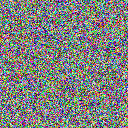

In [45]:
import torchvision.transforms.functional as TF
TF.to_pil_image(rec[5])